In [1]:
using Pkg
Pkg.activate("..")  #one level up, where Project.toml lives
Pkg.instantiate()   #download/install anything missing
# Pkg.status();

  Activating project at `~/Documents/repos/JuliaExploreHRM`


In [116]:
include(joinpath(@__DIR__, "..", "hrm_common.jl"))
using .HRMCommon
using Statistics, Random, Test
using LinearAlgebra: norm
rng = Random.default_rng()



TaskLocalRNG()

In [124]:
using Random, Lux
using .HRMCommon

rng = MersenneTwister(0)
d, L, B = 8, 4, 2
X = randn(Float32, d, L, B)

blk = HRMCommon.TransformerBlock(d; nheads=2, ff_mult=2, positional_encoding_kind=:sinusoidal)
ps, st = Lux.setup(rng, blk)
Y, st2 = Lux.apply(blk, X, ps, st)
@assert size(Y) == (d, L, B)


In [125]:
using Test
using Random, Lux

function _zero_attn_and_ff!(ps)
    ps.m_self_attention.q_proj.weight .= 0
    ps.m_self_attention.k_proj.weight .= 0
    ps.m_self_attention.v_proj.weight .= 0
    ps.m_self_attention.out_proj.weight .= 0
    ps.feedforward.layer.layer_1.weight .= 0
    ps.feedforward.layer.layer_1.bias   .= 0
    ps.feedforward.layer.layer_2.weight .= 0
    ps.feedforward.layer.layer_2.bias   .= 0
    return ps
end

@testset "Tokenwise wrapper = reference reshape" begin
    rng = MersenneTwister(1)
    d, L, B = 8, 7, 3
    X = randn(Float32, d, L, B)

    tw = HRMCommon.Tokenwise(Lux.LayerNorm(d))
    ps_tw, st_tw = Lux.setup(rng, tw)

    # tokenwise path
    Y_tok, _ = Lux.apply(tw, X, ps_tw, st_tw)

    # reference path (manual reshape)
    ps_ln, st_ln = Lux.setup(rng, Lux.LayerNorm(d))
    X2 = reshape(X, d, L*B)
    Y2, _ = Lux.apply(Lux.LayerNorm(d), X2, ps_ln, st_ln)
    Y_ref = reshape(Y2, d, L, B)

    @test size(Y_tok) == size(X)
    @test Y_tok ≈ Y_ref
end

@testset "TransformerBlock identity with positional_encoding_kind=:none when projections are zero" begin
    rng = MersenneTwister(2)
    d, L, B = 8, 5, 2
    X = randn(Float32, d, L, B)

    blk = HRMCommon.TransformerBlock(d; nheads=2, ff_mult=2, positional_encoding_kind=:none)
    ps, st = Lux.setup(rng, blk)
    _zero_attn_and_ff!(ps)

    Y, _ = Lux.apply(blk, X, ps, st)
    @test Y ≈ X
end

@testset "Sinusoidal PE adds a content-independent shift" begin
    rng = MersenneTwister(3)
    d, L, B = 8, 6, 2
    X1 = randn(Float32, d, L, B)
    X2 = randn(Float32, d, L, B)

    blk = HRMCommon.TransformerBlock(d; nheads=2, ff_mult=2, positional_encoding_kind=:sinusoidal)
    ps, st = Lux.setup(rng, blk)
    _zero_attn_and_ff!(ps)  # isolate the positional effect

    Y1, st1 = Lux.apply(blk, X1, ps, st)
    Y2, _   = Lux.apply(blk, X2, ps, st1)

    P1 = Y1 .- X1
    P2 = Y2 .- X2
    @test P1 ≈ P2
    @test any(!iszero, P1)
end

@testset "Gradients flow through m_self_attention and FF" begin
    rng = MersenneTwister(4)
    d, L, B = 8, 7, 3
    X = randn(Float32, d, L, B)
    T = randn(Float32, d, L, B)

    blk = HRMCommon.TransformerBlock(d; nheads=2, ff_mult=2, positional_encoding_kind=:sinusoidal)
    ps, st = Lux.setup(rng, blk)

    # loss over parameters
    loss(ps_) = begin
        Y, _ = Lux.apply(blk, X, ps_, st)
        sum(abs2, Y .- T) / length(Y)
    end
    g_ps = first(Zygote.gradient(loss, ps))

    @test sum(abs2, g_ps.m_self_attention.q_proj.weight) > 0
    @test sum(abs2, g_ps.feedforward.layer.layer_1.weight) > 0

    # loss over input
    lossX(X_) = begin
        Y, _ = Lux.apply(blk, X_, ps, st)
        sum(abs2, Y .- T) / length(Y)
    end
    gX = first(Zygote.gradient(lossX, X))
    @test size(gX) == size(X)
    @test sum(abs2, gX) > 0
end


Test Summary:                         | Pass  Total  Time
Tokenwise wrapper = reference reshape |    2      2  0.0s
Test Summary:                                                                           | Pass  Total  Time
TransformerBlock identity with positional_encoding_kind=:none when projections are zero |    1      1  0.0s
Test Summary:                                  | Pass  Total  Time
Sinusoidal PE adds a content-independent shift |    2      2  0.0s
Test Summary:                                  | Pass  Total  Time
Gradients flow through m_self_attention and FF |    4      4  1.1s


Test.DefaultTestSet("Gradients flow through m_self_attention and FF", Any[], 4, false, false, true, 1.756411289348177e9, 1.756411290418549e9, false, "/home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl")

In [127]:
using Plots, Test

In [128]:


# data generator and quantizer
struct ToyGen
    w::Vector{Float32}
end

function ToyGen(d_in::Int; seed::Int=123)
    Random.seed!(seed)
    w = randn(Float32, d_in)
    return ToyGen(w)
end

"Return (x, y) with shapes (d_in, batch), (1, batch)."
function sample!(gen::ToyGen, batch::Int)
    d = length(gen.w)
    x = randn(Float32, d, batch)
    # linear + small quadratic + noise
    y_lin  = gen.w' * x                                   # (1, B)
    y_quad = 0.1f0 .* sum(abs2, x; dims=1)                # (1, B)
    eps    = 0.01f0 .* randn(Float32, 1, batch)
    y      = Float32.(y_lin .+ y_quad .+ eps)
    return x, y
end

"""
quantize_to_tokens(x; num_tokens, lo, hi)

Uniformly bin each element of x in [lo, hi] into 1..num_tokens.
Values outside [lo, hi] are clamped to the nearest edge bin.
"""
const LO = -3.0
const HI =  3.0

function quantize_to_tokens(x; num_tokens::Int, lo::Real, hi::Real)
    if num_tokens ≤ 0
        error("quantize_to_tokens called with num_tokens ≤ 0; use raw floats instead.")
    end
    @assert num_tokens >= 2
    xn  = @. clamp((x - lo) / (hi - lo + eps(eltype(x))), 0, 1)
    ids = floor.(Int, xn * (num_tokens - 1)) .+ 1
    return ids
end


const CFG = (
    d_in   = 16,
    d_hid  = 64,
    d_out  = 1,
    N      = 2,      # outer HRM cycles
    T      = 3,      # inner timesteps (low-state rollouts)
    M      = 1,      # segments per step
    batch  = 64,
    lr     = 1e-3,
    steps  = 300,
    seed   = 42,

    # input encoding
    num_tokens = 0,  # set >0 to use embeddings with IDs; 0 = raw float encoder
    d_embed    = 32,

    # transformer hyperparameters
    l_heads    = 2,
    l_ff_mult  = 4,
    h_heads    = 2,
    h_ff_mult  = 4,
    dropout    = 0.0
)

Random.seed!(CFG.seed)



loss_fn(yhat, y) = mean(abs2, yhat .- y)


function train_step!(models, ps, st, opt, gen, cfg)
    x, y = sample!(gen, cfg.batch)

    x_in = cfg.num_tokens > 0 ?
           quantize_to_tokens(x; num_tokens=cfg.num_tokens, lo=LO, hi=HI) :
           x  # raw floats

    low_state, high_state = HRMCommon.init_states(cfg.batch, cfg.d_hid)

    # use ps_local here, not ps
    function seg_loss(ps_local)
        yhat, st_new, low_new, high_new =
            HRMCommon.run_segment!(models, ps_local, st, x_in, low_state, high_state;
                                   N=cfg.N, T=cfg.T, cfg=cfg)
        L = loss_fn(yhat, y)
        return L, (st_new, low_new, high_new)
    end

    (L, (st_new, low_new, high_new)), back = Zygote.pullback(seg_loss, ps)
    grads_ps = back((one(L), nothing))[1]      # grads wrt ps
    opt, ps  = Optimisers.update(opt, ps, grads_ps)
    st       = st_new

    # detach recurrent states across steps (kept for future M>1)
    low_state  = Zygote.dropgrad(low_new)
    high_state = Zygote.dropgrad(high_new)

    return Float32(L), ps, st, opt
end


models = HRMCommon.build_models(CFG)
ps, st  = HRMCommon.setup_params_states(models)
opt     = Optimisers.setup(Optimisers.Adam(CFG.lr), ps)
gen     = ToyGen(CFG.d_in; seed=CFG.seed)

# quick shape sanity on blocks themselves
let d=CFG.d_hid, B=CFG.batch
    Xl = randn(Float32, d, 3, B)
    Yl, _ = Lux.apply(models.Lblk, Xl, ps.L, st.L)
    @test size(Yl) == size(Xl)

    Xh = randn(Float32, d, CFG.T, B)
    Yh, _ = Lux.apply(models.Hblk, Xh, ps.H, st.H)
    @test size(Yh) == size(Xh)
end

# train
loss_hist = Float32[]
for step in 1:CFG.steps
    L, ps, st, opt = train_step!(models, ps, st, opt, gen, CFG)
    push!(loss_hist, L)
    if step % 25 == 0
        @info "step=$(step) loss=$(round(L; digits=4))"
    end
end

@test loss_hist[1] > loss_hist[end]


┌ Info: step=25 loss=1.5826
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:130
┌ Info: step=50 loss=1.7296
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:130
┌ Info: step=75 loss=0.6658
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:130
┌ Info: step=100 loss=0.9626
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:130
┌ Info: step=125 loss=0.5639
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transformer_blocks_common/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:130
┌ Info: step=150 loss=0.331
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/04_transfor

Test Passed

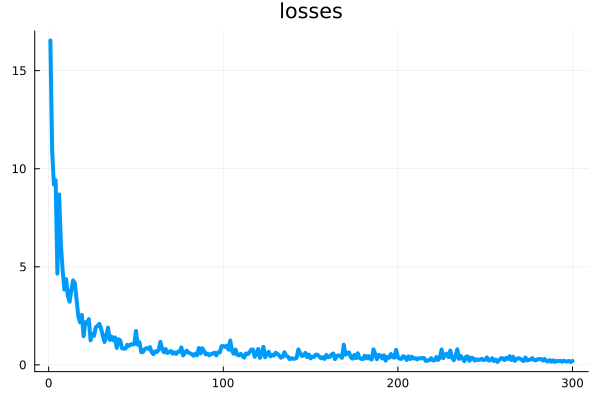

In [129]:
p = plot(loss_hist, title="losses", linewidth=4, legend=false)
savefig(p,"figures/losses.png")
display(p)